Verwendung von Python 3.7.16 enviroment 
Folgende Bibliotheken müssen installiert sein: 
- numpy 
- tensorflow 
- keras 
- sklearn
- matplotlib 
- pandas 

"In diesem Projekt soll es darum gehen, Klassifizierungsalgorithmen auf einen Datensatz loszulassen und ihre Performance zu analysieren. Gegeben ist hierfür ein Datensatz, der Aussagen über den Credit Score einer Person abhängig von mehreren Features wie dem Geschlecht, dem Alter, dem Eigentumsstatus oder dem Einkommen macht. Der Credit Score ist hierbei in 3 Kategorien eingeteilt: Low, Average, Medium. 
Die kategorielle Betrachtung des Credit Scores schreit geradezu nach der Anwendung von Klassifzierungsalgorithmen. Wir fokussieren uns in diesem Projekt auf den K-Nearest Neighbor Algorithmus, den Decision Tree Algorithmus und Neuronale Netze.

In [254]:
# Imports


import tensorflow as tf
from tensorflow import keras 
from tensorflow import convert_to_tensor as to_tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.neighbors import KNeighborsClassifier as knc 
from sklearn.model_selection import train_test_split, cross_val_score as cvaccu, KFold
from sklearn.compose import make_column_selector as selector, ColumnTransformer as ctf
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt 
import pandas as pd
from pandas import read_csv
import numpy as np



In [284]:
# Functions 

def strToInt(df): 
    df_numb = df.select_dtypes(include=["float", 'int'])
    df = df.select_dtypes(exclude=["float", 'int'])
    legend = {}
    for col in df: # Iteration über Spalten
        values = {df[col].iat[0] : 0} # Initiiere dictionary zur Zuordnung String zu Wert
        i = 0
        for value in df[col]: # Iteration über Spalteninhalt
            if value in values: # Wenn value in values (mögliche Zustände von value) enthalten
                df[col].iat[i] = values[value]
            else: # Wenn value noch nicht in values (mögliche Zustände von value) enthalten
                values[value] = len(values.keys()) # ergänze neuen Wert 
                df[col].iat[i] = values[value]
            i += 1 # erhöhe Index
        legend.update(values)
    df = concat([df_numb, df], axis=1) 
        
    return df, legend

def plotData(df): 
    
    # df_np = df.to_numpy
    # Credit Score: 0 (high) --> color = r, 1 (average) --> color = orange, 2 (low) --> color = y
    # Gender: 0 (female) --> marker = o, 1 (male) --> marker = ^
    # Marital Status: 0 (single) --> ms = 8, 0 (married) --> ms = 12
    # Education: 0 (Bachelor's Degree) --> mec = g,  1 (Master's Degree) --> mec = b, 
    #            2 (Doctorate) --> mec = k, 3 (High School Diploma) --> mec = m, 4 (Associate's Degree) --> mec = 'brown'
    # Home Ownership: 0 (rented) --> alpha = 0.5, 1 (owned) --> alpha = 1 
    # Number of Children: Different subplots
    
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 8))
    
    for index, row in df.iterrows():
        # Score encoding
        if ((row['Credit Score'] == 0) or (row['Credit Score'] == 'High')): 
            color = 'r'
        elif ((row['Credit Score'] == 1) or (row['Credit Score'] == 'Average')):
             color = 'orange'
        else: 
            color = 'y'
            
        # Gender encoding    
        if ((row['Gender'] == 0) or (row['Gender'] == 'Female')): 
            marker = 'o'
        else: 
            marker = '^'
            
        # Marital Status encoding 
        if ((row['Marital Status'] == 0) or (row['Marital Status'] == 'Single')): 
            ms = 8
        else: 
            ms = 12
        
        # Home Ownership encoding 
        if ((row['Home Ownership'] == 0) or (row['Home Ownership'] == 'Rented')): 
            alpha = 0.5
        else: 
            alpha = 1
            
        # Education encoding 
        if ((row['Education'] == 0) or (row['Education'] == "Bachelor's Degree")): 
            mec = 'g'
        elif ((row['Education'] == 1) or (row['Education'] == "Master's Degree")): 
            mec = 'b'
        elif ((row['Education'] == 2) or (row['Education'] == "Doctorate")):
            mec = 'k'
        elif ((row['Education'] == 3) or (row['Education'] == "High School Diploma")):
            mec = 'm'
        else: 
            mec = 'brown'
         
        # Number of Children encoding
        if row['Number of Children'] == 0: 
            subplt = 1
            title = '0 Children(s)'
        elif row['Number of Children'] == 1:
            subplt = 2
            title = '1 Children(s)'
        elif row['Number of Children'] == 2:
            subplt = 3
            title = '2 Children(s)'
        else: 
            subplt = 4
            title = '3 Children(s)'
        
        plt.subplot(4, 1, subplt) 
        plt.tight_layout()
        plt.plot(row['Income'], row['Age'], marker=marker, color=color, 
                 markersize=ms, markeredgecolor=mec, markeredgewidth=3, alpha=alpha)
        plt.title(title)
    
    # # Erstellung Fake-Daten für legend (visible=False)
    # plt.subplot(4,1,4)
    # plt.plot(50000,50, marker='*', color='r', visible=False, label='High Credit Score')
    # plt.plot(50000,50, marker='*', color='orange', visible=False, label='Average Credit Score')
    # plt.plot(50000,50, marker='o', color='y', visible=False, label='Low Credit Score')
    # plt.plot(50000,50, marker='o', visible=False, label='Female')
    # plt.plot(50000,50, marker='^', visible=False, label='Male')
    # plt.legend(loc='lower left')
    
    # Einheitliches Layout der Subplots
    for i in range(4): 
        plt.subplot(4,1,i+1)    
        plt.xticks(np.arange(10000, 190000, 20000))
        plt.yticks(np.arange(20, 70, 10))
        
        plt.xlabel('Income', loc='left')
        plt.ylabel('Age')
        plt.grid(color='grey', linestyle=':', linewidth=1, alpha=0.5)
 
    plt.savefig('Datenplot.png', format='png', bbox_inches="tight")

    return 

def scalerChoice(scalernames):
    n = len(scalernames)
    scaler = []
    for scalername in scalernames: 
        if (scalername.upper().replace(' ','') == 'STANDARD') or (
            scalername.upper().replace(' ','') == 'STANDARDSCALER'):
                scaler.append(StandardScaler())
        elif (scalername.upper().replace(' ','') == 'MINMAX') or (
            scalername.upper().replace(' ','') == 'MINMAXSCALER'):
                scaler.append(MinMaxScaler())
        else: 
            raise ValueError('Wähle Standard oder MinMax als scaler')

    return scaler

def createDenseModel(n_layers, n_neurons,  acti, loss, lr, optimizer, metrics): 
    
    model = Sequential()
    for i in range(n_layers):
        model.add(Dense(n_neurons[i], activation=acti[i]))
   
    opti = SGD(learning_rate=lr)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model 

def cvaccu_nn(n_folds, model, X, y): 
    
    kf = KFold(n_splits=n_folds)
    accu = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(to_tf(X_train,dtype=tf.float32), to_tf(y_train,dtype=tf.float32),batch_size=4, epochs=10, verbose=0)
        accu.append(model.evaluate(to_tf(X_test,dtype=tf.float32), to_tf(y_test,dtype=tf.float32),verbose=0)[1])
    
    return accu 

def toOneHotArray(x):
    x0 = np.zeros(len(x))
    max_idx = np.argmax(x)
    x = x0
    x[max_idx] = 1
    return x

Datenvorbereitung 

/opt/anaconda3/envs/deeplearning_env/lib/python3.7/site-packages/pandas/core/series.py:1169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(loc, value)


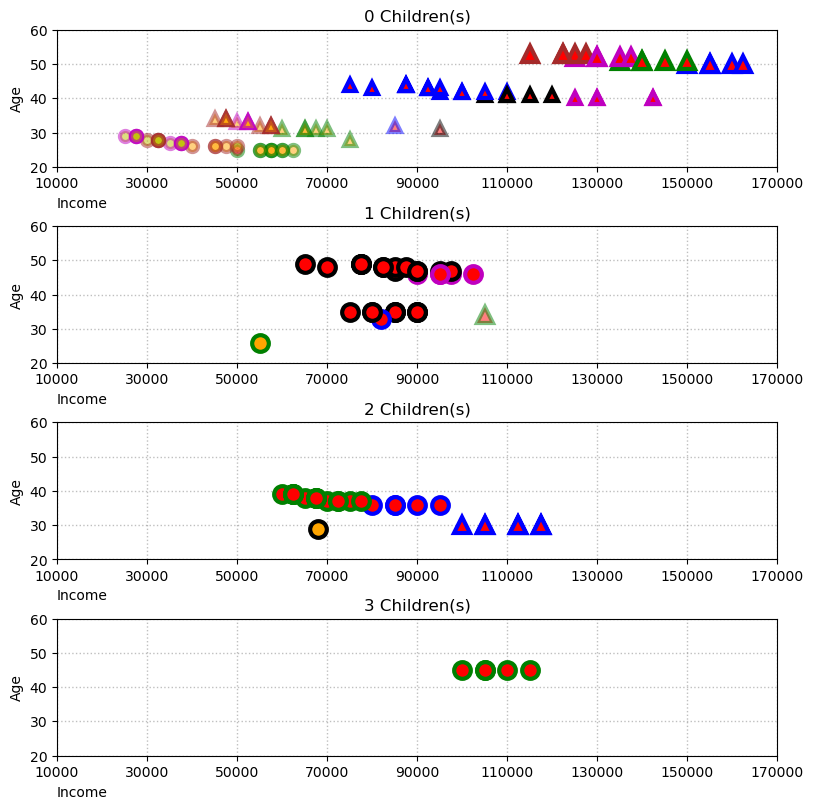

In [236]:
# Preprocessing

df = read_csv('./CreditScores.csv') 
df, legend = strToInt(df)
creditScore = df['Credit Score']
data_unscaled = df.drop(columns=['Credit Score'])

plotData(df) # Plot der Daten zur Visualisierung 



In [285]:
# Normierung

## Wähle Scaler für num. Werte der jeweiligen Netzwerke:
model_name = ['KNN', 'Decision Tree', 'Neural Network'] # Modellnamen 
scalernames = ['Standard', 'MinMax', 'MinMax'] # [0]: KNN, [1]: Decision Tree, [2]: Neural Network
scaler = scalerChoice(scalernames) 

## Normierung
data_scaled = np.array([None, None, None])
for i in range(3): # Normierung der Daten mit jeweiligen Scaler
    data_scaled[i] = scaler[i].fit_transform(data_unscaled) 

## Umwandlung kategorische Werte in OneHot-Arrays
creditScore_cat = to_categorical(creditScore, num_classes=3) 


In [99]:
# Vorbereitung ColumnTransformer für Pipeline

## ColumnSelector für jeweiliges Netzwerk (KNN, Tree) vorbereiten
selector_num = selector(dtype_include=["float", 'int'])
selector_cat = selector(dtype_exclude=["float", 'int'])

col_num = [None, None]
col_cat = [None, None]
for i in range(2): # nur 2, da Pipeline nur für KNN und Tree
    col_num[i] = selector_num(data_unscaled) # Auswahl numerische Spalten
    col_cat[i] = selector_cat(data_unscaled) # Auswahl kategoriale Spalten

## CloumnTransformer instanziieren 
ct = [None, None]
for i in range(2): 
    ct[i] = ctf([ #Transformer mit scaler[i] für numiersche Werte und OneHotEncoder für kategorische Werte
    ("OneHotEncoder", OneHotEncoder(), col_cat[i]), 
    (scalerChoice[i], scaler[i], col_num[i])
])


ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(),
                                 ['Gender', 'Education', 'Marital Status',
                                  'Home Ownership']),
                                ('MinMax', MinMaxScaler(),
                                 ['Age', 'Income', 'Number of Children'])])


In [277]:
# Trainings- und Testdaten vorbereiten 

## Erstellung Trainings- und Testdaten für jeweiliges Netzwerk erstellen
in_train = np.array([None, None, None]) # jeweilige Inputs für Training
in_test = np.array([None, None, None]) # jeweilige Inputs für Test 
out_train = np.array([None]) # jeweilige Outputs für Training
out_test = np.array([None]) # jeweilige Outputs für Test
seed = 12 # für random_state 
test_size = 0.2 # 80% Training, 20% Test/Evaluierung
for i in range(3): 
    in_train[i], in_test[i], out_train, out_test = train_test_split(data_scaled[i], creditScore_cat, test_size=test_size, random_state=seed)

## Umwandlung Daten für KNN und Tree wieder in pandas Dataframe-Format, da kein Dataframe-Format mehr
for i in range(2): 
    in_train[i] = pd.DataFrame(in_train[i], columns=data_unscaled.columns)
    in_test[i] = pd.DataFrame(in_test[i], columns=data_unscaled.columns)



In [278]:
# ML-Modelle K-Nearest-Neighbourhood (KNN) & Decision Tree (tree)

## Erstellung Modell
model = [None, None, None] 
clf = [knc(n_neighbors=2, weights='distance'), dtc()] # Instanziierung jeweiliger Classifier
for i in range(2): # KNN und Tree
    model[i]= make_pipeline(ct[i], clf[i])

## Training 
for i in range(2): 
    model[i].fit(in_train[i], out_train)




In [279]:
# Neuronales Netzwerk (NN)

## Erstellung
model[2] = createDenseModel(
    n_layers=3, 
    n_neurons=[7,16,3],
    acti=['relu', 'relu', 'softmax'],
    loss='categorical_crossentropy', 
    lr=0.005, 
    optimizer=SGD(),
    metrics='accuracy'
)

## Training
model[2].fit(in_train[2], out_train, 
             batch_size=4, epochs=1000, verbose=1)

Epoch 1/1000
33/33 [==============================] - 1s 2ms/step - loss: 1.0085 - accuracy: 0.6718
Epoch 2/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.9089 - accuracy: 0.6870
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.8270 - accuracy: 0.6870
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.7704 - accuracy: 0.6870
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.7289 - accuracy: 0.6870
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.6972 - accuracy: 0.6870
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.6738 - accuracy: 0.6870
Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.6561 - accuracy: 0.6870
Epoch 9/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.6424 - accuracy: 0.6870
Epoch 10/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.6309 - accuracy: 0.6870

In [280]:
# # Print True Label vs Predicted Label des jeweiligen Netzwerks

# for i in range(3): 
#     print(model_name[i])
#     print("True Label \t Predicted Label")
#     if i < 2:
#         for j in range(len(out_test)):
#             print(out_test[j] ,'\t', model[i].predict(in_test[i])[j]) 
#     else:
#         for j in range(len(out_test)):
#             print(out_test[j] ,'\t', toOneHotArray(model[i].predict(in_test[i],verbose=0)[j]))   


Die Accuracy vom KNN Modell ist: 1.000
Die Accuracy vom Decision Tree Modell ist: 0.970
Die Accuracy vom Neural Network Modell ist: 1.000
2/2 [==============================] - 0s 5ms/step


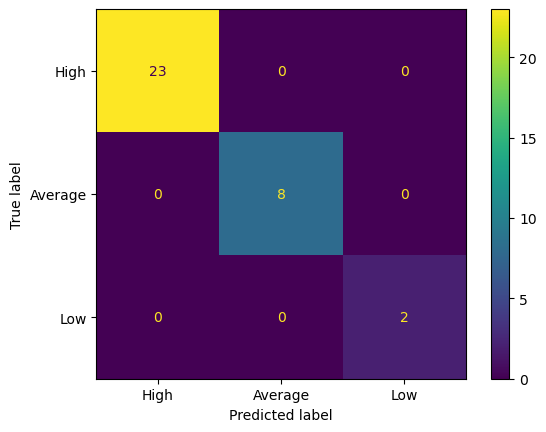

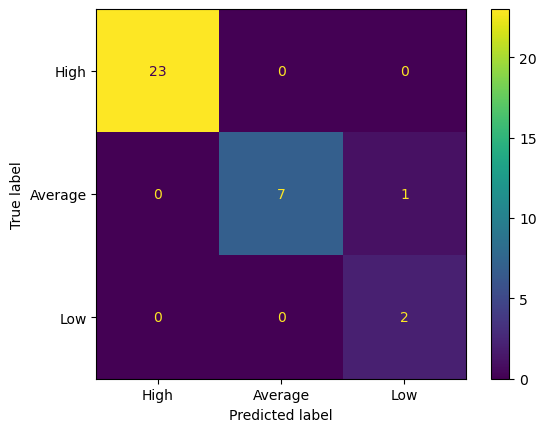

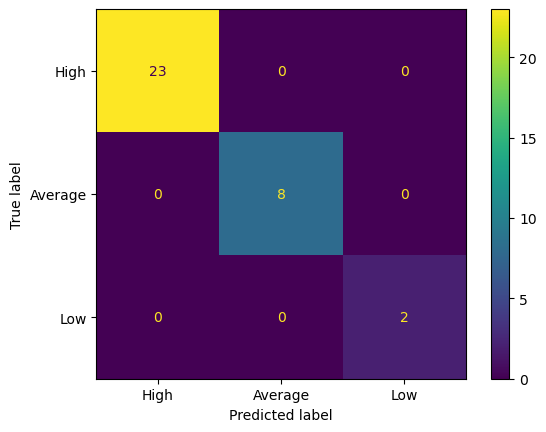

In [281]:
# Evaluierung

## Bestimmung Accuracy
accu = [None, None, None] 
for i in range(2): 
    accu[i] = accuracy_score(out_test, model[i].predict(in_test[i]))
accu[2] = model[2].evaluate(in_test[2], out_test, verbose=0)[1]

for i in range(3):
    print(f"Die Accuracy vom {model_name[i]:} Modell ist: {accu[i]:.3f}")
    

## Confusion Matrix 
cm = [None, None, None]
for i in range(3):
    label_true = out_test.argmax(axis=1)
    label_pred = model[i].predict(in_test[i]).argmax(axis=1)
    cm[i] = confusion_matrix(label_true, label_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=['High','Average','Low'])
    disp.plot()
    disp.figure_.savefig('ConfusionMatrix'+model_name[i].replace(' ','')+'.png')
    

In [282]:
# Cross-Validierung

cv = [None, None, None]
scoring='accuracy'
n_cv = 5
for i in range(2): 
    cv[i]= cvaccu(model[i], pd.DataFrame(data_scaled[i], columns=data_unscaled.columns), creditScore_cat, cv=n_cv)
cv[2] = cvaccu_nn(n_folds=n_cv, model=model[2], X=data_scaled[2], y=creditScore_cat)

for i in range(3):
    print(f"Die mittlere Accuracy ± Standardabweichung der Cross-Validierung vom {model_name[i]} Modell ist: {np.mean(cv[i]):.3f} ± {np.std(cv[i]):.3f}")


Die mittlere Accuracy ± Standardabweichung der Cross-Validierung vom KNN Modell ist: 0.975 ± 0.023
Die mittlere Accuracy ± Standardabweichung der Cross-Validierung vom Decision Tree Modell ist: 0.975 ± 0.030
Die mittlere Accuracy ± Standardabweichung der Cross-Validierung vom Neural Network Modell ist: 0.994 ± 0.012
